# Loading Libraries

In [1]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('bert-base-nli-mean-tokens')

/commuter/thierrylincoln/.cache/torch/sentence_transformers/public.ukp.informatik.tu-darmstadt.de_reimers_sentence-transformers_v0.2_bert-base-nli-mean-tokens.zip


In [7]:
import numpy as np
np.set_printoptions(suppress=True) #prevent numpy exponential 

model.encode(["my mother is sick and i have financial difficulties. I am divorced also"])

[array([ 0.00026447,  0.16941774,  0.4509423 ,  0.01881915,  0.19452624,
         0.91911244,  0.60828376,  0.05799139,  0.17649847, -0.4495058 ,
        -0.01688554,  0.6660129 ,  1.2315656 ,  1.1778224 , -0.20616107,
        -0.04666847, -0.00546318,  0.10735901, -0.07147362, -0.4834915 ,
        -0.4784032 ,  0.18505844,  0.63270825, -0.23175709,  0.13114347,
         0.40267813, -0.36294466, -1.1757288 , -1.6983649 , -0.3508907 ,
         0.25376192, -0.44633162,  0.47577798,  0.19205558,  0.6596816 ,
        -0.23029524,  0.46686906, -0.30155355, -0.07460146, -0.14916183,
         0.603663  ,  0.24931717, -0.10463461,  0.5971307 ,  0.40123546,
        -0.45532835,  0.03623329,  0.36160755,  0.1883594 , -1.3847661 ,
        -0.14273348, -0.07762055,  1.9015106 ,  1.0202463 , -0.48401994,
         0.00049112, -0.25858095, -0.7537316 , -0.5307483 ,  0.31092167,
         0.5056139 , -0.07798848, -0.12542261,  0.39558196, -1.2184391 ,
         0.20326139, -0.04166707,  0.5526479 , -0.6

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
import sys
import os
import pandas as pd
import numpy as np


from datetime import datetime

import matplotlib.pyplot as plt
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import f1_score,confusion_matrix,classification_report,accuracy_score

import logging
logging.basicConfig(stream=sys.stdout, level=logging.ERROR)



pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 1000)

## Utils functions 

In [3]:
def create_examples_prediction(df):
    """Creates examples for the training and dev sets."""
    examples = []
    for index, row in df.iterrows():
        
        #labels = row[LABEL_HOT_VECTOR].strip('][').split(', ')
        #labels = [float(x) for x in labels]
        labels = list(row[label_list_text])
        examples.append(labels)
        
    return pd.DataFrame(examples)

In [4]:
def f(x):
    n = 2  # index of the second proability to get labeled 

    index = np.argsort(x.values.flatten().tolist())[-n:][0]
    print(f"index is {index}")
    label  = label_list_text[index]
    print(f"label is {label}")
    
    return label
    

In [5]:
def get_test_experiment_df(test):
    test_predictions = [x[0]['probabilities'] for x in zip(getListPrediction(in_sentences=list(test[DATA_COLUMN])))]
    test_live_labels = np.array(test_predictions).argmax(axis=1)
    test['Predicted label'] = [label_list_text[x] for x in test_live_labels] # appending the labels to the dataframe
    
    probabilities_df_live = pd.DataFrame(test_predictions) # creating a proabilities dataset
    probabilities_df_live.columns = [x + " Predicted"for x in label_list_text] # naming the columns
    probabilities_df_live['Predicted label 2'] = probabilities_df_live.apply(lambda x:f(x),axis=1)
    
    #print(test)
    #label_df = create_examples_prediction(test)
    #label_df.columns = label_list_text
    #label_df['label 2'] = label_df.apply(lambda x:f(x),axis=1)

    test.reset_index(inplace=True,drop=True) # resetting index 

    experiment_df = pd.concat([test,probabilities_df_live],axis=1, ignore_index=False)
    experiment_df = experiment_df.reindex(sorted(experiment_df.columns), axis=1)
    return test,experiment_df

In [6]:
def getListPrediction(in_sentences):
    #1
    input_examples = [InputExample(guid="", text_a = x, text_b = None, labels = [0]*len(label_list)) for x in in_sentences] # here, "" is just a dummy label
    
    #2
    input_features = convert_examples_to_features(input_examples, MAX_SEQ_LENGTH, tokenizer)
    
    #3
    predict_input_fn = input_fn_builder(features=input_features, seq_length=MAX_SEQ_LENGTH, is_training=False, drop_remainder=False)
    
    print(input_features[0].input_ids)
    #4
    predictions = estimator.predict(input_fn=predict_input_fn,yield_single_examples=True)
    
    return predictions

In [7]:
is_normalize_active=False

def get_confusion_matrix(y_test,predicted,labels):
    class_names=labels
    # plotting confusion matrix
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plot_confusion_matrix(y_test, predicted, classes=class_names,
                        title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plot_confusion_matrix(y_test, predicted, classes=class_names, normalize=True,
                        title='Normalized confusion matrix')
    plt.show()
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes =classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        test =1
        #print('Confusion matrix, without normalization')

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    #ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    #fig.tight_layout()
    return ax

def plot_matrix(cm,classes,title=None,cmap=plt.cm.Reds):
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    #ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f'
    thresh = cm.max() / 2.5
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    #fig.tight_layout()
    return ax

# Loading the data

In [8]:
def data_prep_bert(df,test_size):
    
    #print("Filling missing values")
    #df[DATA_COLUMN] = df[DATA_COLUMN].fillna('_NA_')
    
    print("Splitting dataframe with shape {} into training and test datasets".format(df.shape))
    X_train, X_test  = train_test_split(df, test_size=test_size, random_state=2018,stratify = df[LABEL_COLUMN_RAW])

    return X_train, X_test


In [9]:
def open_dataset(NAME,mapping_index,excluded_categories):
    df = pd.read_csv(PATH+NAME+'.csv',sep =',')
    
    #df[LABEL_COLUMN_RAW] = df[LABEL_COLUMN_RAW].fillna("Other")

    
    df = df[df['is_stressor'] == 1]
    df = df[df[LABEL_COLUMN_RAW] != 'Not Stressful']
    #df.columns = [LABEL_COLUMN_RAW,'Severity',DATA_COLUMN,'Source']
    
    if excluded_categories is not None:
        for category in excluded_categories:

            df = df[df[LABEL_COLUMN_RAW] !=category]

    label_list=[]
    label_list_final =[]
    if(mapping_index is None):
        df[LABEL_COLUMN_RAW] = df[LABEL_COLUMN_RAW].astype('category')
        df[LABEL_COLUMN], mapping_index = pd.Series(df[LABEL_COLUMN_RAW]).factorize() #uses pandas factorize() to convert to numerical index
        
  
    else:
        df[LABEL_COLUMN] = df[LABEL_COLUMN_RAW].apply(lambda x: mapping_index.get_loc(x))
    
    label_list_final = [None] * len(mapping_index.categories)
    label_list_number = [None] * len(mapping_index.categories)

    for index,ele in enumerate(list(mapping_index.categories)):
        lindex = mapping_index.get_loc(ele)
        label_list_number[lindex] = lindex
        label_list_final[lindex] = ele
    
    frequency_dict = df[LABEL_COLUMN_RAW].value_counts().to_dict()
    df["class_freq"] = df[LABEL_COLUMN_RAW].apply(lambda x: frequency_dict[x])
    
    
    return df,mapping_index,label_list_number,label_list_final
    

# Require user changes > Start Here 

### Experiment Name

In [10]:
PATH = './datasets/'
TODAY_DATE = "01_05_2020/"
EXPERIMENT_NAME = 'main_turk_analysis_of_5_turkers_popbots_test_live_10votes'
EXPERIMENTS_PATH = PATH + 'experiments/'+TODAY_DATE+EXPERIMENT_NAME
if not os.path.exists(PATH + 'experiments/'+TODAY_DATE):
    os.mkdir(PATH + 'experiments/'+TODAY_DATE)
if not os.path.exists(EXPERIMENTS_PATH):
    os.mkdir(EXPERIMENTS_PATH)

### Model Hyperparameters

In [11]:
# Compute train and warmup steps from batch size
# These hyperparameters are copied from this colab notebook (https://colab.sandbox.google.com/github/tensorflow/tpu/blob/master/tools/colab/bert_finetuning_with_cloud_tpus.ipynb)
BATCH_SIZE = 32
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 3.0
# Warmup is a period of time where hte learning rate 
# is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 1000
SAVE_SUMMARY_STEPS = 100

# We'll set sequences to be at most 32 tokens long.
MAX_SEQ_LENGTH = 32


OUTPUT_DIR = './models/'+EXPERIMENT_NAME+ '/' #_01_04_2020/

##use downloaded model, change path accordingly
BERT_VOCAB= './bert_model/uncased_L-12_H-768_A-12/vocab.txt'
BERT_INIT_CHKPNT = './bert_model/uncased_L-12_H-768_A-12/bert_model.ckpt'
BERT_CONFIG = './bert_model/uncased_L-12_H-768_A-12/bert_config.json'


In [12]:
DATASET_NAME = '2020-04-28-Main-turk-aggregation-5-turkers'

DATA_COLUMN = 'Input.text'
LABEL_COLUMN_RAW = 'labels'#'Answer.Label'
LABEL_COLUMN = 'label_numeric'

MTURK_NAME = 'mTurk_synthetic'
LIVE_NAME = 'popbots_live'

LABEL_HOT_VECTOR = 'label_conf'

#dataset,mapping_index,label_list, label_list_text = open_dataset('mturk900balanced',None)

EXCLUDED_CATEGORIES = None #['Other'] #None # # if nothing to exclude put None, THIS ALWAYS MUST BE A LIST 
mapping_dict = {'Other': 0, 'Everyday Decision Making': 1, 'Work': 2, 'Social Relationships': 3, 'Financial Problem': 4, 'Emotional Turmoil': 5, 'Health, Fatigue, or Physical Pain': 6, 'School': 7, 'Family Issues': 8}#,'Not Stressful':9}
mapping_index = pd.CategoricalIndex([key for key,value in mapping_dict.items()])

dataset,mapping_index,label_list, label_list_text = open_dataset(DATASET_NAME,mapping_index,EXCLUDED_CATEGORIES)

#dataset = dataset[dataset['is_stressor'] == 1]

test_on_mturk_and_popbots_live = True # include live data in training + include mturk in testing


if test_on_mturk_and_popbots_live:
    
    mturk = dataset[dataset['Source']== MTURK_NAME]
    live = dataset[dataset['Source']== LIVE_NAME]
    live = live.sample(frac=1).reset_index(drop=True) # shuffle live
    
    PERCENTAGE_LIVE_TEST = 70
    
    TEST_PERCENTAGE = len(live)/((100/PERCENTAGE_LIVE_TEST)*len(mturk))  # given to set the percentage of mturk used as test set to have 50/50
    
    print(f"Test percentage is {TEST_PERCENTAGE}")

    train,test = data_prep_bert(mturk,TEST_PERCENTAGE) # test size from mturk 
    
    train = train.append(live.loc[0:int((1-(PERCENTAGE_LIVE_TEST/100))*len(live))]) # taking 1/2 of that dataset for training
    
    test = test.append(live.loc[int(len(live)*(1-(PERCENTAGE_LIVE_TEST/100))):int(len(live))]) # taking 1/2 of live dataset for testing
else:
    # or taking live only for testing
    train,test = dataset[dataset['Source']== MTURK_NAME],dataset[dataset['Source']== LIVE_NAME] 

#train = train[train['is_stressor'] == 1] # remove only non stressor from train

#print(f"Dataset has {len(dataset)} training examples")
print(f"Normal label list is {label_list}")
print(f"The labels text is {label_list_text}")

#Export train test to csv
#train.to_csv(PATH+'900_CSV_SPLITTED/train.csv')
#test.to_csv(PATH+'900_CSV_SPLITTED/test.csv')

Test percentage is 0.050670241286863274
Splitting dataframe with shape (1865, 21) into training and test datasets
Normal label list is [0, 1, 2, 3, 4, 5, 6, 7, 8]
The labels text is ['Other', 'Everyday Decision Making', 'Work', 'Social Relationships', 'Financial Problem', 'Emotional Turmoil', 'Health, Fatigue, or Physical Pain', 'School', 'Family Issues']


In [40]:

df_columns = ['category', 'nb_sentence','nb_sentence_sampled','mean_distinct_word_nb','mean_distinc_word_per_sentence', 'sd','sd per sentence', '95conf_int' ]
count_results = pd.DataFrame(columns = df_columns)

boostrap_number = 50
for category in label_list_text:
    len_word_distinct_word = 0
    len_word_distinct_word_list = []
    for i in range(boostrap_number):
        category_df = dataset[dataset[LABEL_COLUMN_RAW] == category].sample(n=38)
        category_df_unsampled = dataset[dataset[LABEL_COLUMN_RAW] == category]
        results = set()
        category_df[DATA_COLUMN].str.lower().str.split().apply(results.update)
        
        len_word_distinct_word += len(list(results))
        len_word_distinct_word_list.append(len(list(results)))
    count_results = count_results.append({'category':category,
                                          'nb_sentence':len(category_df_unsampled),
                                          'nb_sentence_sampled':len(category_df),'mean_distinct_word_nb':len_word_distinct_word/boostrap_number,
                                          'mean_distinc_word_per_sentence':len_word_distinct_word/boostrap_number/len(category_df),'sd':0,
                                          'list_distinct':len_word_distinct_word_list},
                                         ignore_index=True)



In [13]:
def return_conf_interval(stats):
    alpha = 0.95
    p = ((1.0-alpha)/2.0) * 100
    lower = max(0.0, np.percentile(stats, p))
    p = (alpha+((1.0-alpha)/2.0)) * 100
    upper = min(1.0, np.percentile(stats, p))
    
    return ["{0:.4f}".format(lower),"{0:.4f}".format(upper)]

In [42]:

count_results['sd']= count_results['list_distinct'].apply(lambda x:np.std(np.array(x), axis=0))
count_results['sd per sentence']= count_results['sd']/38


count_results['95conf_int']= count_results['list_distinct'].apply(lambda x:return_conf_interval([x/38 for x in x]))


count_results[df_columns].sort_values(by=['mean_distinc_word_per_sentence'])

,category,nb_sentence,nb_sentence_sampled,mean_distinct_word_nb,mean_distinc_word_per_sentence,sd,sd per sentence,95conf_int
7,School,158,38,167.10,4.397368,10.423531,0.274303,"[3.92, 4.91]"
4,Financial Problem,339,38,182.22,4.795263,13.154908,0.346182,"[4.18, 5.39]"
6,"Health, Fatigue, or Physical Pain",129,38,185.40,4.878947,9.335952,0.245683,"[4.39, 5.34]"
2,Work,709,38,186.22,4.900526,10.587332,0.278614,"[4.41, 5.34]"
1,Everyday Decision Making,116,38,194.42,5.116316,10.501600,0.276358,"[4.69, 5.60]"
0,Other,111,38,196.28,5.165263,11.173254,0.294033,"[4.61, 5.70]"
3,Social Relationships,127,38,201.38,5.299474,11.735229,0.308822,"[4.82, 5.87]"
5,Emotional Turmoil,76,38,206.10,5.423684,8.080223,0.212637,"[5.03, 5.78]"
8,Family Issues,235,38,207.86,5.470000,12.271935,0.322946,"[4.84, 6.13]"


In [19]:
np.set_printoptions(threshold=np.inf,suppress=True)

df_columns = ['category', 'nb_sentence','mean_sd','sd_mean_sd','95conf_int']
count_results = pd.DataFrame(columns = df_columns)

boostrap_number = 1
for category in label_list_text:

    boostrap_sd = []
    all_mean = []
    for i in range(boostrap_number):
        category_df = dataset[dataset[LABEL_COLUMN_RAW] == category].sample(n=38)
        category_df_unsampled = dataset[dataset[LABEL_COLUMN_RAW] == category]
        
        category_df['embedding'] = model.encode(category_df[DATA_COLUMN].values)
        category_df['embedding'] = category_df['embedding'].apply(lambda x: np.array(x))
        average_mean = np.mean(np.array(category_df['embedding'].values),axis=0) # vector of 768 dim
        average_sd = np.std(np.array(category_df['embedding'].values),axis=0) # vector of 768 dim
        overall_sd = np.std(average_sd) # overall sd
        boostrap_sd.append(overall_sd)
        all_mean.append(average_mean)
    
    print(np.array(all_mean).shape)
    mean_all_mean = np.mean(np.array(all_mean),axis=0)
    print(np.array(mean_all_mean).shape)
    print(category)
    print(list(mean_all_mean))



    count_results = count_results.append({'category':category,\
                                          'nb_sentence':len(category_df_unsampled),\
                                          'nb_sentence_sampled':len(category_df),
                                          'mean_sd':float(overall_sd),
                                          'all_sd':boostrap_sd,
                                          'mean_vector':mean_all_mean},ignore_index=True)



(1, 768)
(768,)
Other
[0.1960404, 0.14447224, 1.2651811, 0.1108821, -0.16382782, 0.18633614, 0.39686632, 0.2368233, 0.2965561, -0.44451788, -0.36494887, 0.34411344, 0.4052361, 0.43122983, 0.20277584, 0.23506264, -0.04767337, -0.37237194, -0.101587296, -0.40140587, -0.016515583, -0.29303226, 0.29152822, -0.41935214, 0.21541448, -0.21471591, -0.3068513, -0.40749058, -1.016066, -0.05147582, -0.05012486, -0.12859257, 0.17026907, 0.010007702, -0.076924875, 0.46755973, 0.3788722, -0.27495566, 0.018810337, -0.06837327, 0.3268556, 0.12824874, 0.028674556, 0.2803442, -0.24058342, -0.31172252, 0.502649, 0.14405432, 0.3780724, -1.1382123, -0.20111628, 0.2636489, 0.94899637, 0.6809327, -0.39051145, -0.027287653, 0.06520737, -1.0647501, -0.33397377, 0.09565813, -0.11932936, 0.09622953, 0.13651761, 0.3008418, -0.6525546, 0.16430205, 0.0033335593, -0.07357472, -0.5710674, -0.59322417, 0.23716432, -0.8152262, -0.34731463, -0.17473584, -0.53006285, -0.47711232, 0.17543216, 0.37277982, 0.53360194, 0.662

(1, 768)
(768,)
Social Relationships
[0.17217417, 0.30587003, 1.3630569, 0.025481677, -0.20332058, 0.29533747, 0.7907195, 0.271843, 0.23741187, -0.27700463, -0.52442193, 0.3144372, 0.5344742, 0.6045489, -0.33037317, 0.32314685, 0.061551947, -0.3468399, 0.012949498, -0.5785828, -0.102554366, -0.26914743, 0.24566866, -0.39252195, 0.3994222, 0.16266267, -0.185659, -0.7424843, -0.8811497, 0.032348767, -0.027282573, 0.17054416, 0.1518163, -0.01168157, -0.16913848, 0.21330266, 0.46558866, -0.17559135, 0.07827361, -0.21281624, 0.42623565, 0.1618126, -0.12023222, 0.17165671, -0.40620604, -0.22159946, 0.47459736, 0.12946904, 0.37972108, -1.3138806, -0.30898076, 0.09177712, 1.1491575, 0.56359076, -0.5070156, -0.10950079, 0.054158926, -1.2130705, -0.216272, 0.12121428, -0.3606495, 0.18674448, 0.10540062, 0.25378564, -0.7217994, 0.28246126, 0.12051366, -0.004716878, -0.4062468, -0.6954989, 0.19432127, -0.7030592, -0.25170964, -0.30480355, -0.3590827, -0.4599341, 0.117632024, 0.29384822, 0.7887626,

(1, 768)
(768,)
Health, Fatigue, or Physical Pain
[0.40650603, 0.15112408, 1.321666, -0.104231864, -0.3648821, 0.418216, 0.686742, 0.16876487, 0.2984003, -0.5768633, -0.1403491, 0.48458964, 0.6012115, 0.6900748, 0.30165467, 0.3237575, 0.34688085, -0.5748889, -0.07628904, -0.44651508, -0.091510415, -0.31718752, 0.48854592, -0.50029415, 0.04014173, -0.102006584, -0.50597835, -0.5901075, -1.1642052, -0.14252, 0.0794403, -0.19354905, 0.110033184, 0.071646474, 0.35228345, 0.44357085, 0.4425475, -0.32388872, 0.11420221, -0.44030672, 0.72639817, 0.017847205, -0.19508024, 0.37996972, -0.070614874, -0.15920933, 0.4723173, -0.15555942, 0.37936875, -1.2273327, -0.28308108, 0.12870626, 1.391146, 0.59092456, -0.48197356, -0.21986711, 0.15733856, -0.68652517, -0.1757623, 0.36512563, 0.13367903, 0.2449404, -0.20427042, 0.5091491, -1.001358, 0.26493165, -0.08309202, 0.08343818, -0.27729806, -0.5482817, 0.25147274, -0.67966574, -0.13013501, -0.36401865, -0.41853207, -0.3414947, 0.17046946, 0.15312868, 

In [121]:
count_results['sd_mean_sd']= count_results['all_sd'].apply(lambda x:np.std(np.array(x), axis=0))
count_results['95conf_int']= count_results['all_sd'].apply(lambda x:return_conf_interval([x for x in x]))

count_results[df_columns].sort_values(by=['mean_sd'])

,category,nb_sentence,mean_sd,sd_mean_sd,95conf_int
2,Work,709,0.093737,0.004011,"[0.0907, 0.1049]"
6,"Health, Fatigue, or Physical Pain",129,0.094886,0.004019,"[0.0919, 0.1062]"
7,School,158,0.097140,0.002918,"[0.0937, 0.1046]"
5,Emotional Turmoil,76,0.100048,0.003363,"[0.0947, 0.1059]"
4,Financial Problem,339,0.101100,0.003235,"[0.0908, 0.1024]"
8,Family Issues,235,0.102215,0.003675,"[0.0920, 0.1050]"
3,Social Relationships,127,0.102797,0.002987,"[0.0959, 0.1062]"
1,Everyday Decision Making,116,0.103827,0.002254,"[0.1022, 0.1106]"
0,Other,111,0.110782,0.002335,"[0.1040, 0.1121]"


In [122]:
count_results['mean_vector'] = count_results['mean_vector'].apply(lambda x: np.array(x).T)


In [123]:
lis = [vector for vector in np.array(count_results['mean_vector'])]

In [124]:
from sklearn.metrics.pairwise import cosine_similarity as cs

ortho = pd.DataFrame(cs(lis,lis))
ortho.index =label_list_text
ortho.columns  = label_list_text
ortho

,Other,Everyday Decision Making,Work,Social Relationships,Financial Problem,Emotional Turmoil,"Health, Fatigue, or Physical Pain",School,Family Issues
Other,1.000001,0.945472,0.898901,0.919552,0.872108,0.941655,0.895254,0.847971,0.883898
Everyday Decision Making,0.945472,1.000000,0.910248,0.897586,0.888413,0.903773,0.880513,0.855723,0.869525
Work,0.898901,0.910248,1.000000,0.890535,0.884516,0.890946,0.855525,0.865205,0.866671
Social Relationships,0.919552,0.897586,0.890535,1.000000,0.867216,0.940938,0.888482,0.842829,0.948510
Financial Problem,0.872108,0.888413,0.884516,0.867216,1.000000,0.867918,0.849766,0.806127,0.845645
Emotional Turmoil,0.941655,0.903773,0.890946,0.940938,0.867918,1.000000,0.938988,0.805747,0.913563
"Health, Fatigue, or Physical Pain",0.895254,0.880513,0.855525,0.888482,0.849766,0.938988,1.000000,0.810973,0.886263
School,0.847971,0.855723,0.865205,0.842829,0.806127,0.805747,0.810973,1.000000,0.848796
Family Issues,0.883898,0.869525,0.866671,0.948510,0.845645,0.913563,0.886263,0.848796,1.000000


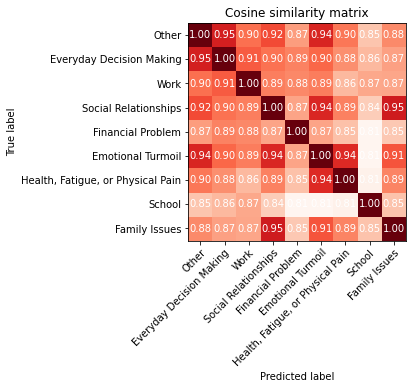

In [142]:
plot_matrix(cm=np.array(ortho),title="Cosine similarity matrix",classes=label_list_text)

### Train set and test set analysis

In [407]:
def print_dataset_info(train,test):
    print(f"Train size {len(train)} with {len(train[train['Source']== LIVE_NAME])} from Popbots and {len(train[train['Source']== MTURK_NAME])} from mturk")
    print(f"Test size {len(test)} with {len(test[test['Source']== LIVE_NAME])} from Popbots and {len(test[test['Source']== MTURK_NAME])} from mturk")
    
    print('\nTraining distribution:')
    print(pd.pivot_table(train[[LABEL_COLUMN_RAW, 'Source']],index=[LABEL_COLUMN_RAW, 'Source'],columns=None, aggfunc=len)) #.to_clipboard(excel=True)
          
    print('\nTesting distribution:')
    print(pd.pivot_table(test[[LABEL_COLUMN_RAW, 'Source']],index=[LABEL_COLUMN_RAW, 'Source'],columns=None, aggfunc=len)) #.to_clipboard(excel=True)

In [408]:
len(test)

135

In [409]:
train = train.sample(frac=1).reset_index(drop=True) #reshuffle everything
test = test.sample(frac=1).reset_index(drop=True)

In [410]:
print('\nAll dataset distribution:')
print(pd.pivot_table(dataset[[LABEL_COLUMN_RAW, 'Source']],index=[LABEL_COLUMN_RAW, 'Source'],columns=None, aggfunc=len)) #.to_clipboard(excel=T


All dataset distribution:
labels                             Source         
Emotional Turmoil                  mTurk_synthetic     70
                                   popbots_live         6
Everyday Decision Making           mTurk_synthetic     99
                                   popbots_live        17
Family Issues                      mTurk_synthetic    225
                                   popbots_live        10
Financial Problem                  mTurk_synthetic    337
                                   popbots_live         2
Health, Fatigue, or Physical Pain  mTurk_synthetic    109
                                   popbots_live        20
Other                              mTurk_synthetic     97
                                   popbots_live        14
School                             mTurk_synthetic    145
                                   popbots_live        13
Social Relationships               mTurk_synthetic    113
                                   popbots_live     

In [420]:
print_dataset_info(train,test)

Train size 1811 with 41 from Popbots and 1770 from mturk
Test size 190 with 95 from Popbots and 95 from mturk

Training distribution:
labels                             Source         
Emotional Turmoil                  mTurk_synthetic     66
                                   popbots_live         2
Everyday Decision Making           mTurk_synthetic     94
                                   popbots_live         4
Family Issues                      mTurk_synthetic    214
                                   popbots_live         2
Financial Problem                  mTurk_synthetic    320
Health, Fatigue, or Physical Pain  mTurk_synthetic    103
                                   popbots_live         6
Other                              mTurk_synthetic     92
                                   popbots_live         5
School                             mTurk_synthetic    138
                                   popbots_live         3
Social Relationships               mTurk_synthetic    107
   

### Step to reduce the most dominant categories and balance the dataset

In [323]:
sampling_cutoff = 100 # all the categories which had less than 100 example won't be sampled down
total_training_size = 1501

REVERSE_FREQ = 'Max_reverse_sampling_chance'
train[REVERSE_FREQ] = train['class_freq'].apply(lambda x: (max(train['class_freq'])/x)) 

sampling_boolean = (train['Source'] != LIVE_NAME) & (train['class_freq'].astype(float) > sampling_cutoff) 


train_to_be_balanced = train[sampling_boolean]
train_not_resampled = train[~sampling_boolean]

train_temp = train_to_be_balanced.sample(n=(total_training_size-len(train_not_resampled)), weights=REVERSE_FREQ, random_state=2020)
train = pd.concat([train_temp,train_not_resampled])

In [324]:
print_dataset_info(train,test)

Train size 1501 with 0 from Popbots and 1501 from mturk
Test size 135 with 135 from Popbots and 0 from mturk

Training distribution:
labels                             Source         
Emotional Turmoil                  mTurk_synthetic     70
Everyday Decision Making           mTurk_synthetic     99
Family Issues                      mTurk_synthetic    209
Financial Problem                  mTurk_synthetic    273
Health, Fatigue, or Physical Pain  mTurk_synthetic    109
Other                              mTurk_synthetic     97
School                             mTurk_synthetic    140
Social Relationships               mTurk_synthetic    113
Work                               mTurk_synthetic    391
dtype: int64

Testing distribution:
labels                             Source      
Emotional Turmoil                  popbots_live     6
Everyday Decision Making           popbots_live    17
Family Issues                      popbots_live    10
Financial Problem                  popbots_live 

In [325]:
mapping_index

CategoricalIndex(['Other', 'Everyday Decision Making', 'Work',
                  'Social Relationships', 'Financial Problem',
                  'Emotional Turmoil', 'Health, Fatigue, or Physical Pain',
                  'School', 'Family Issues'],
                 categories=['Emotional Turmoil', 'Everyday Decision Making', 'Family Issues', 'Financial Problem', 'Health, Fatigue, or Physical Pain', 'Other', 'School', 'Social Relationships', ...], ordered=False, dtype='category')

In [326]:
train.to_csv(EXPERIMENTS_PATH+'/TRAIN_'+DATASET_NAME+'.csv')
test.to_csv(EXPERIMENTS_PATH+'/TEST_'+DATASET_NAME+'.csv')